# <a href="http://www.datascience-paris-saclay.fr">Paris Saclay Center for Data Science</a>
# <a href=https://www.ramp.studio/problems/air_passengers>RAMP</a> on predicting the number of air passengers

<i> Balázs Kégl (LAL/CNRS), Alex Gramfort (LTCI/Telecom ParisTech), Djalel Benbouzid (UPMC), Mehdi Cherti (LAL/CNRS) </i>

## Introduction
The data set was donated to us by an unnamed company handling flight ticket reservations. The data is thin, it contains
<ul>
<li> the date of departure
<li> the departure airport
<li> the arrival airport
<li> the mean and standard deviation of the number of weeks of the reservations made before the departure date
<li> a field called <code>log_PAX</code> which is related to the number of passengers (the actual number were changed for privacy reasons)
</ul>

The goal is to predict the <code>log_PAX</code> column. The prediction quality is measured by RMSE. 

The data is obviously limited, but since data and location informations are available, it can be joined to external data sets. <b>The challenge in this RAMP is to find good data that can be correlated to flight traffic</b>.

In [1]:
%matplotlib inline
import imp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
pd.set_option('display.max_columns', None)

In [2]:
# !pip install -U seaborn  # if you don't have it, or pip3 for python3

In [3]:
# optional
import seaborn as sns; sns.set()

In [4]:
#!pip install https://api.github.com/repos/paris-saclay-cds/ramp-workflow/zipball/master

## Fetch the data and load it in pandas

First we load `problem.py` that parameterizes the challenge. It contains some objects taken off the shelf from `ramp-workflow` (e.g., `Predictions` type, scores, and data reader). 

In [5]:
problem = imp.load_source('', 'problem.py')

`get_train_data` loads the training data and returns an `pandas` object (input) and a `np.array` object (output).

In [6]:
X_df, y_array = problem.get_train_data()

## Building predictive models

### The feature extractor

The feature extractor implements a single <code>transform</code> function. It receives the full pandas object X_df (without the labels). It should produce a numpy array representing the features extracted. If you want to use the (training) labels to save some state of the feature extractor, you can do it in the fit function.

The starting kit feature extractor shows you how to join your data to external data. You will have the possibility to submit a single external csv for each of your submission (so if you have several data sets, you first have to do the join offline, and save it as a csv). In this case it is whether data, joined to the database on the <code>DateOfDeparture</code> and <code>Arrival</code> fields. Attention: when you join the data, make sure that the <b><font color=red>order</font> of the rows in the data frame does not change</b>.

In [7]:
import pandas as pd
import os


class FeatureExtractor(object):
    def __init__(self):
        pass

    def fit(self, X_df, y_array):
        pass

    def transform(self, X_df):
        # Read external data file
        path = os.path.dirname(__file__)
        data_weather = pd.read_csv(os.path.join(path, 'external_data.csv'))

        X_encoded = X_df.copy()
        
        # Manage the date of departure 
        X_encoded['DateOfDeparture'] = pd.to_datetime(X_encoded['DateOfDeparture'], format="%Y-%m-%d")

        X_encoded['year'] = X_encoded['DateOfDeparture'].dt.year
        X_encoded['month'] = X_encoded['DateOfDeparture'].dt.month
        X_encoded['day'] = X_encoded['DateOfDeparture'].dt.day
        X_encoded['weekday'] = X_encoded['DateOfDeparture'].dt.weekday
        X_encoded['week'] = X_encoded['DateOfDeparture'].dt.week
        X_encoded['n_days'] = X_encoded['DateOfDeparture'].apply(lambda date: (date - pd.to_datetime("1970-01-01")).days)
        X_encoded['isweekend']=X_encoded['DateOfDeparture'].dt.weekday.isin([5,6]).astype(int)
    
        # Manage the date feature
        data_weather['Date_dt'] = pd.to_datetime(data_weather['Date'], format="%Y-%m-%d")
        data_weather = data_weather.drop('Date', axis=1)

        X_weather = data_weather[['Date_dt', 'AirPort', 'Events','Mean TemperatureC','Mean Humidity', \
                                  'Mean VisibilityKm','Mean Wind SpeedKm/h','CloudCover']]
        # List of colonne to use:  ,'Mean TemperatureC','Dew PointC','Mean Humidity', \
        #                          'Mean Sea Level PressurehPa','Mean VisibilityKm','Mean Wind SpeedKm/h','CloudCover'

        X_weather = X_weather.rename(
            columns={'Date_dt': 'DateOfDeparture', 'AirPort': 'Arrival'})

        X_encoded = pd.merge(
            X_encoded, X_weather, how='left',
            left_on=['DateOfDeparture', 'Arrival'],
            right_on=['DateOfDeparture', 'Arrival'],
            sort=False)

        #X_encoded = X_encoded.join(pd.get_dummies(X_encoded['Departure'], prefix='d'))
        #X_encoded = X_encoded.join(pd.get_dummies(X_encoded['Arrival'], prefix='a'))
        #X_encoded = X_encoded.join(pd.get_dummies(X_encoded['Events']))
        X_encoded['Departure_enc'] = pd.factorize(X_encoded['Departure'])[0]
        X_encoded['Arrival_enc'] = pd.factorize(X_encoded['Arrival'])[0]
        X_encoded['Events_enc'] = pd.factorize(X_encoded['Events'])[0]

        X_encoded = X_encoded.drop('Departure', axis=1)
        X_encoded = X_encoded.drop('Arrival', axis=1)
        X_encoded = X_encoded.drop('Events', axis=1)
                
        #X_encoded = X_encoded.join(pd.get_dummies(X_encoded['year'], prefix='y'))
        X_encoded = X_encoded.join(pd.get_dummies(X_encoded['weekday'], prefix='wd'))
        X_encoded = X_encoded.join(pd.get_dummies(X_encoded['week'], prefix='w'))

        #X_encoded = X_encoded.join(pd.get_dummies(X_encoded['month'], prefix='m'))
        #X_encoded = X_encoded.join(pd.get_dummies(X_encoded['day'], prefix='d'))
        #X_encoded = X_encoded.drop('year', axis=1)
        #X_encoded = X_encoded.drop('month', axis=1)
        #X_encoded = X_encoded.drop('day', axis=1)
        #X_encoded = X_encoded.drop('weekday', axis=1)
        #X_encoded = X_encoded.drop('week', axis=1)
        
        
        X_encoded = X_encoded.drop('DateOfDeparture', axis=1)

        self.X_encoded=X_encoded
        X_array = X_encoded.values
        return X_array
    
    def get_encoded(self):
        return self.X_encoded
        pass

In [8]:
# we need this because the global variable __file__ (the path of the current file)
# does not exist if we are in a notebook
__file__ = 'submissions/starting_kit/'
fe = FeatureExtractor()
fe.fit(X_df, y_array)
X_array = fe.transform(X_df)
X_array.shape

(8902, 76)

In [9]:
X_df_transf=fe.get_encoded()


In [10]:
X_df_transf

,WeeksToDeparture,std_wtd,year,month,day,weekday,week,n_days,isweekend,Mean TemperatureC,Mean Humidity,Mean VisibilityKm,Mean Wind SpeedKm/h,CloudCover,Departure_enc,Arrival_enc,Events_enc,wd_0,wd_1,wd_2,wd_3,wd_4,wd_5,wd_6,w_1,w_2,w_3,w_4,w_5,w_6,w_7,w_8,w_9,w_10,w_11,w_12,w_13,w_14,w_15,w_16,w_17,w_18,w_19,w_20,w_21,w_22,w_23,w_24,w_25,w_26,w_27,w_28,w_29,w_30,w_31,w_32,w_33,w_34,w_35,w_36,w_37,w_38,w_39,w_40,w_41,w_42,w_43,w_44,w_45,w_46,w_47,w_48,w_49,w_50,w_51,w_52
0,12.875000,9.812647,2012,6,19,1,25,15510,0,29,63,16,29,5,0,0,-1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,14.285714,9.466734,2012,9,10,0,37,15593,0,25,14,16,15,3,1,1,-1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,10.863636,9.035883,2012,10,5,4,40,15618,0,19,77,13,8,5,2,2,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
3,11.480000,7.990202,2011,10,9,6,40,15256,1,19,58,16,6,1,3,3,-1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
4,11.450000,9.517159,2012,2,21,1,8,15391,0,12,79,12,8,7,2,4,-1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8897,9.263158,7.316967,2011,10,2,6,39,15249,1,14,51,16,16,0,13,16,-1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
8898,12.772727,10.641034,2012,9,25,1,39,15608,0,17,68,16,15,3,8,3,-1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
8899,11.047619,7.908705,2012,1,19,3,3,15358,0,8,31,16,8,6,4,6,-1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8900,6.076923,4.030334,2013,2,3,6,5,15739,1,-1,72,13,9,7,0,14,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


### The regressor

The regressor should implement an sklearn-like regressor with `fit` and `predict` functions.

In [12]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import BayesianRidge
#from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingRegressor
import xgboost as xgb

from sklearn.base import BaseEstimator

class Regressor(BaseEstimator):
    def __init__(self):
        #self.reg = RandomForestRegressor(n_estimators=100, max_depth=50, max_features=17)
        #self.reg = LinearRegression()
        #self.reg = Lasso(alpha=0.1)
        #self.reg = BayesianRidge()
        #self.reg  = GradientBoostingRegressor(n_estimators=50, subsample=0.9, max_depth=10)
        #self.reg  =GradientBoostingRegressor(learning_rate=0.1,n_estimators=620,max_depth=22)
        self.reg = xgb.XGBRegressor(objective ='reg:linear',nthreads=-1, colsample_bytree = 0.939621, learning_rate = 0.144394, \
                max_depth = 10, alpha = 10, n_estimators = 199,subsample=0.936487)
        
    def fit(self, X, y):
        self.reg.fit(X, y)

    def predict(self, X):
        return self.reg.predict(X)

In [104]:
reg = Regressor()
reg.fit(X_array, y_array)
y_pred = reg.predict(X_array)
score_type = problem.score_types[0]

[15:55:52] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [105]:
score = score_type(y_array, y_pred)
score

0.04218763902379042

In [106]:
# Optimization des paramètres

In [107]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_array, y_array, random_state=42)

In [ ]:
from sklearn.pipeline import Pipeline

model = Pipeline([
    ('clf', RandomForestRegressor(n_jobs=-1, random_state=42))
])

In [ ]:
_=model.fit(X_train,y_train)

In [ ]:
model.score(X_test, y_test)

In [ ]:
from scipy.stats import randint
from sklearn.model_selection import RandomizedSearchCV

param_distributions = {
    'clf__n_estimators': randint(1, 400),
    'clf__max_depth': randint(2, 200),
    'clf__max_features': [14,15,16,17],
    'clf__min_samples_split': [2, 3, 4, 5,6,7,8,9, 10],
}
search = RandomizedSearchCV(
    model, param_distributions=param_distributions,
    n_iter=30, n_jobs=-1, cv=5
)

In [ ]:
from scipy.stats import 

In [ ]:
#_ = search.fit(X_train, y_train)

In [ ]:
df_results = pd.DataFrame(search.cv_results_)
columns_to_keep = [
    "param_" + param_name for param_name in param_distributions]
columns_to_keep += [
    'mean_test_score',
    'std_test_score',
]
df_results = df_results[columns_to_keep]
df_results = df_results.sort_values(by="mean_test_score", ascending=False)
df_results.head(5)

In [18]:
# (X)Gradiant Boosting Forest

In [108]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_array, y_array, random_state=42)

In [109]:
from sklearn.pipeline import Pipeline
from sklearn.ensemble import GradientBoostingRegressor
import xgboost as xgb

model_GB = Pipeline([
    ('clf', GradientBoostingRegressor())
])
model_XGB = Pipeline([
    ('xgb', xgb.XGBRegressor(objective ='reg:linear',nthreads=-1))
])

In [110]:
from scipy.stats import randint
from scipy.stats import reciprocal
from scipy.stats import uniform

from sklearn.model_selection import RandomizedSearchCV

from xgboost.sklearn import XGBRegressor  
import scipy.stats as st

one_to_left = st.beta(10, 1)  
from_zero_positive = st.expon(0, 50)

params = {  
    "n_estimators": st.randint(3, 200),
    "max_depth": st.randint(3, 40),
    "learning_rate": st.uniform(0.01, 0.5),
    "colsample_bytree": one_to_left,
    "subsample": one_to_left
    #"gamma": st.uniform(0, 10),
    #'reg_alpha': from_zero_positive,
    #"min_child_weight": from_zero_positive,
}

xgbreg = XGBRegressor(nthreads=-1)  
gs = RandomizedSearchCV(xgbreg, params, n_jobs=1)  


In [111]:
# Search for Parameters
_=gs.fit(X_train, y_train)  


/Users/christophenoblanc/anaconda3/envs/dssp/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


[15:56:47] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:56:47] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:56:48] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:56:49] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:56:52] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:56:55] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:56:58] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:57:02] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:57:07] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

In [112]:
gs.n_iter

10

In [113]:
df_results = pd.DataFrame(gs.cv_results_)
columns_to_keep = [
    "param_" + param_name for param_name in params]
columns_to_keep += [
    'mean_test_score',
    'std_test_score',
]
df_results = df_results[columns_to_keep]
df_results = df_results.sort_values(by="mean_test_score", ascending=False)
#df_results.head(5)
df_results

,param_n_estimators,param_max_depth,param_learning_rate,param_colsample_bytree,param_subsample,mean_test_score,std_test_score
3,120,16,0.122122,0.964245,0.898837,0.763912,0.012891
5,128,19,0.151776,0.995872,0.960198,0.751805,0.007856
6,88,13,0.266196,0.904535,0.933431,0.749757,0.009133
2,196,14,0.337645,0.849798,0.916346,0.735071,0.016053
4,63,25,0.0721434,0.871436,0.995817,0.728541,0.020352
1,77,18,0.338204,0.942573,0.945058,0.716957,0.030419
9,152,4,0.381952,0.957795,0.700686,0.715391,0.019902
0,51,4,0.445045,0.986472,0.838816,0.711961,0.024366
7,32,24,0.294851,0.988716,0.858622,0.694588,0.018239
8,21,33,0.194533,0.659019,0.936676,0.667795,0.003229


In [ ]:
#X_train
import xgboost as xgb
estimator=xgb.XGBRegressor(objective ='reg:linear', colsample_bytree = 0.939621, learning_rate = 0.144394, \
                max_depth = 10, alpha = 10, n_estimators = 199,subsample=0.936487, nthreads=-1)

model_xgb=estimator.fit(X_train, y_train)


In [93]:
X_columns = X_df_transf.columns
print(model_xgb.feature_importances_)

[2.0654271e-03 1.1127386e-03 5.0994847e-04 1.5476439e-03 1.2219880e-03
 5.8464380e-03 9.3518915e-03 3.0054825e-03 9.6833758e-02 2.0196191e-03
 1.3027928e-03 1.2255568e-03 1.1388593e-03 8.6746039e-04 6.6012410e-03
 5.5453773e-03 5.9577059e-03 6.5059680e-03 4.7526010e-03 1.1827046e-02
 6.3034343e-03 1.5354949e-02 1.9310543e-02 8.2740979e-03 1.6490096e-02
 2.1042207e-02 3.6880206e-03 2.1422498e-02 4.6505276e-03 1.3875031e-02
 7.6051895e-03 1.2830072e-02 6.2060948e-03 6.9477651e-03 8.3672013e-03
 8.1096003e-03 1.6152492e-02 6.9653383e-03 8.5969362e-03 1.8166779e-02
 6.2496471e-03 1.6795754e-02 3.5146091e-02 9.0135746e-03 2.0438796e-02
 2.6728705e-02 1.3726583e-02 2.3716791e-02 4.3165116e-03 2.6641848e-02
 6.6643534e-03 2.0068249e-02 1.1051405e-02 1.1812204e-02 1.6271069e-03
 3.4181611e-03 8.1191014e-05 3.2441393e-03 0.0000000e+00 1.0833699e-03
 2.6363647e-03 8.0814882e-04 3.8918927e-03 3.9955825e-03 0.0000000e+00
 1.4120056e-03 9.8719122e-04 1.7601516e-03 0.0000000e+00 1.0692781e-03
 7.834

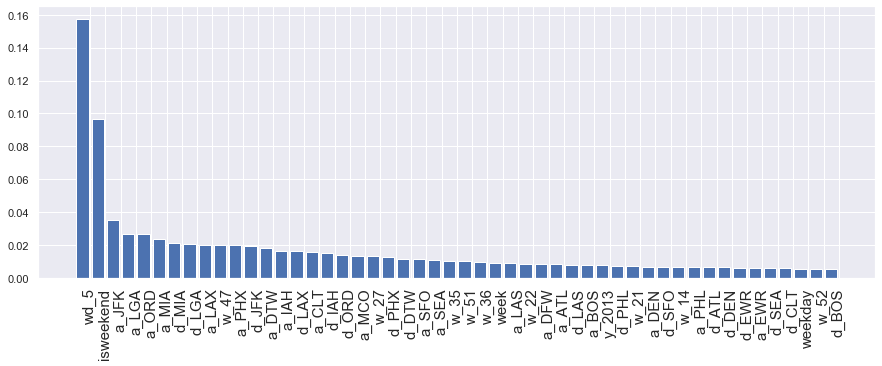

In [94]:
# Selection des meilleurs features
from sklearn.feature_selection import SelectFromModel

plt.figure(figsize=(15, 5))

ordering = np.argsort(model_xgb.feature_importances_)[::-1][:50]

importances = model_xgb.feature_importances_[ordering]
feature_names = X_columns[ordering]

x = np.arange(len(feature_names))
plt.bar(x, importances)
plt.xticks(x + 0.5, feature_names, rotation=90, fontsize=15);

In [114]:
# use feature importance for feature selection
from numpy import loadtxt
from numpy import sort
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.feature_selection import SelectFromModel

# split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_array, y_array, test_size=0.33, random_state=42)

# fit model on all training data
model_xgb = XGBClassifier()
model_xgb.fit(X_train, y_train)
# make predictions for test data and evaluate
y_pred = model_xgb.predict(X_test)
predictions = [round(value) for value in y_pred]
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))
# Fit model using each importance as a threshold
thresholds = sort(model_xgb.feature_importances_)


ValueError: Classification metrics can't handle a mix of continuous and multiclass targets

In [ ]:
for thresh in thresholds:
	# select features using threshold
	selection = SelectFromModel(model_xgb, threshold=thresh, prefit=True)
	select_X_train = selection.transform(X_train)
	# train model
	selection_model = XGBClassifier()
	selection_model.fit(select_X_train, y_train)
	# eval model
	select_X_test = selection.transform(X_test)
	y_pred = selection_model.predict(select_X_test)
	predictions = [round(value) for value in y_pred]
	accuracy = accuracy_score(y_test, predictions)
	print("Thresh=%.3f, n=%d, Accuracy: %.2f%%" % (thresh, select_X_train.shape[1], accuracy*100.0))

In [ ]:
from sklearn.feature_selection import SelectFromModel
feature_selector = SelectFromModel(self._selector_clf, prefit=True, threshold=0.20)

# remove unimportant features
X_array = self._selector.transform(X_encoded)

## Local testing (before submission)

It is <b><span style="color:red">important that you test your submission files before submitting them</span></b>. For this we provide a unit test. Note that the test runs on your files in [`submissions/starting_kit`](http://localhost:8890/tree/submissions/starting_kit).

First `pip install ramp-workflow` or install it from the [github repo](https://github.com/paris-saclay-cds/ramp-workflow). Make sure that the python files `feature_extractor.py`, `regressor.py`, and `external_data.csv` are in the  [`submissions/starting_kit`](http://localhost:8890/tree/submissions/starting_kit) folder, and the data `train.csv.bz2` and `test.csv.bz2` are in [`data`](http://localhost:8890/tree/data). Then run

```ramp_test_submission```

If it runs and print training and test errors on each fold, then you can submit the code.

In [ ]:
#!ramp_test_submission
!ramp_test_submission --submission=dummies

Alternatively, load and execute `rampwf.utils.testing.py`, and call `assert_submission`. This may be useful if you would like to understand how we instantiate the workflow, the scores, the data connectors, and the cross validation scheme defined in [`problem.py`](problem.py), and how we insert and train/test your submission.

In [ ]:
# %load https://raw.githubusercontent.com/paris-saclay-cds/ramp-workflow/master/rampwf/utils/testing.py

In [ ]:
# assert_submission()

## Submitting to [ramp.studio](http://ramp.studio)

Once you found a good model, you can submit it to [ramp.studio](http://www.ramp.studio). First, if it is your first time using RAMP, [sign up](http://www.ramp.studio/sign_up), otherwise [log in](http://www.ramp.studio/login). Then find an open event on the particular problem, for example, the event [DSSP 6](https://www.ramp.studio/events/air_passengers_dssp6) for this RAMP. Sign up for the event. Both signups are controled by RAMP administrators, so there **can be a delay between asking for signup and being able to submit**.

Once your signup request is accepted, you can go to your [sandbox](http://www.ramp.studio/events/air_passengers_dssp6/sandbox) and copy-paste (or upload) [`feature_extractor.py`](http://localhost:8890/edit/submissions/starting_kit/feature_extractor.py), [`regressor.py`](http://localhost:8890/edit/submissions/starting_kit/regressor.py), and [`external_data.csv`](http://localhost:8890/edit/submissions/starting_kit/external_data.csv) from `submissions/starting_kit`. Save it, rename it, then submit it. The submission is trained and tested on our backend in the same way as `ramp_test_submission` does it locally. While your submission is waiting in the queue and being trained, you can find it in the "New submissions (pending training)" table in [my submissions](http://www.ramp.studio/events/air_passengers_dssp6/my_submissions). Once it is trained, you get a mail, and your submission shows up on the [public leaderboard](http://www.ramp.studio/events/air_passengers_dssp6/leaderboard). 
If there is an error (despite having tested your submission locally with `ramp_test_submission`), it will show up in the "Failed submissions" table in [my submissions](http://www.ramp.studio/events/air_passengers_dssp6/my_submissions). You can click on the error to see part of the trace.

After submission, do not forget to give credits to the previous submissions you reused or integrated into your submission.

The data set we use at the backend is usually different from what you find in the starting kit, so the score may be different.

The usual way to work with RAMP is to explore solutions, add feature transformations, select models, perhaps do some AutoML/hyperopt, etc., _locally_, and checking them with `ramp_test_submission`. The script prints mean cross-validation scores 
```
----------------------------
train rmse = 0.748 ± 0.0117
valid rmse = 0.858 ± 0.0111
test rmse = 0.881 ± 0.005
```
The official score in this RAMP (the first score column after "historical contributivity" on the [leaderboard](http://www.ramp.studio/events/air_passengers_dssp6/leaderboard)) is root mean squared error ("rmse"), so the line that is relevant in the output of `ramp_test_submission` is `valid rmse = 0.858 ± 0.0111`. When the score is good enough, you can submit it at the RAMP.

## More information

You can find more information in the [README](https://github.com/paris-saclay-cds/ramp-workflow/blob/master/README.md) of the [ramp-workflow library](https://github.com/paris-saclay-cds/ramp-workflow).

## Contact

Don't hesitate to [contact us](mailto:admin@ramp.studio?subject=air passengers notebook).